# Hopfield - Self-attention - Prototype (Pooling)
The update of the new energy function (notebook [3_hopfield-continuous-value.ipynb](./3_hopfield-continuous-value.ipynb)) is the self-attention of transformer networks.

References:
* https://ml-jku.github.io/hopfield-layers/#update

From equation:
$$
\xi^{new} = X\mathrm{softmax}(\beta X^T \xi)
$$

For $S$ state patterns $\Xi=(\xi_1,...,\xi_s)$, the equation can be generalized to:
$$
\Xi^{\mathrm{new}} = X\mathrm{softmax}(\beta X^T\Xi)
$$

Where $X^T$ can be considered as $N$ *raw **stored** patterns* $Y=(y_1,...y_N)^T$, which are mapped to an associative space via $W_K$, and $\Xi^T$ as $S$ *raw **state** patterns* $R=(\xi_1,...,\xi_S)^T$, which are mapped to an associative space via $W_Q$.

Then, by setting:
$$
Q = \Xi^T = RW_Q \\
K = X^T = YW_K \\
\beta = \frac{1}{\sqrt{d_k}}
$$

we obtain:
$$
(Q^{\mathrm{new}})^T = K^T \mathrm{softmax}(\frac{1}{\sqrt{d_k}}KQ^T)
$$

Where $W_Q$ and $W_K$ are matrices which map the respective patterns into the associative space. In the previous equation, the softmax is applied column-wise tot he matrix $KQ^T$. By transposing the equation, which also means softmax is now applied row-wise to its transposed input $QK^T$, we obtain:

$$
(Q^{\mathrm{new}})^T = \mathrm{softmax}(\frac{1}{\sqrt{d_k}}QK^T)K
$$

Now, by projecting $Q^{new}$ via another projection matrix $W_V$ we obtain:

$$
Z = Q^{new}W_V = \mathrm{softmax}(\frac{1}{\sqrt{d_k}}QK^T)KW_V = \mathrm{softmax}(\frac{1}{\sqrt{d_k}}QK^T)V
$$

Which is basically the transformer attention formula (As per Attention is All you need):
$$
\mathrm{Attention(Q, K, V)} = \mathrm{softmax}(\frac{QK^T}{\sqrt{d_k}})V
$$

Some remarks:
* Transformer based models usually implement embedding layers before the attention mechanism, i.e., what is feed into the attention mechanism is an embedding of the input/outputs.
    * These embeddings have trainable matrices that produces them during training.
* In the new Hopfield definition, the matrices that produce the embeddings are explicit in the formula, i.e., matrices $W_Q$, $W_K$, and $W_V$ are the matrices that transform the input/outpus into the associative space that is feed to the attention mechanism.
* One differencing aspect of original attention vs Hopfield is the value of $\beta$ parameter. Original attention fixes this to be dependent on the dimension of the embeddings, which for large values of $d_k$ will yield in smaller $\beta$, which in turn, as per explained in the new Hopfield paper, means the retrievals will tend to be metastable states or the average of similar patterns which can give us an intuition of why they work and why the concept of "Attention".
* The new Hopfield definition can be interpreted as a generalization of the attention mechanism.
* The result of the retrieval, which is the attention produced from the state patterns against the stored patterns, can be the input to fully connected layers for some classification task.
* Similarly, before the attention mechanism, there can be other feature extraction layers s.a. CNNs that will produce vectors for which store/retrieval process can be applied.

## Hopfield MNIST #1 - Predict using full patterns


In [1]:
import numpy as np
import torch
from torchvision.datasets import MNIST
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.nn.functional as F

random_seed = 1234
train_split_fraction = 0.7
np.random.seed(random_seed)
torch.manual_seed(random_seed)

data_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]
)

train_set = MNIST(
    './mnist-train', 
    train=True, 
    download=True, 
    transform=data_transform,
    )

test_set = MNIST(
    './mnist-test', 
    train=False, 
    download=True, 
    transform=data_transform,
    )

train_set_size = len(train_set)
indices = list(range(train_set_size))
np.random.shuffle(indices)
split = int(np.floor(train_split_fraction * train_set_size))
stored_patterns_idx, train_idx = indices[split:], indices[:split]

stored_patterns_sampler = SubsetRandomSampler(stored_patterns_idx)
train_sampler = SubsetRandomSampler(train_idx)

train_loader = DataLoader(train_set, batch_size=2048, shuffle=True, num_workers=4)
test_loader = DataLoader(test_set, batch_size=2048, shuffle=True, num_workers=4)
stored_patterns_loader = DataLoader(train_set, batch_size=split, sampler=stored_patterns_sampler)
stored_patterns = list(stored_patterns_loader)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
def prepare_device(obj, use_cuda: bool = True):
    """Prepare device.
    Moves the passed object to the appropriate
    device."""
    if use_cuda and torch.cuda.is_available():
        return obj.to("cuda")
    return obj

Simple Hopfield network definition representing the generalized attention mechanism:
$$
Z = \mathrm{softmax}(\beta \cdot RW_QW_K^TY^T)YW_KW_V
$$

Where $R$ are the raw state patterns, and $Y$ are the raw stored patterns. Notice that $V$ is represented by $YW_KW_V$ in this case. But the key point is that the model is flexible and either some, all or none of the elements can be trainable ($W$ matrices associated with each element.)

In [7]:
import torch.nn as nn
import torch

class HopfieldNet(nn.Module):
    def __init__(
        self,
        store_dim: int, 
        hidden_store_dim: int, 
        dropout_ratio: float = 0.3):
        super().__init__()
        
        self.store_dim = store_dim
        self.hidden_store_dim = hidden_store_dim
        self.dropout_ratio = dropout_ratio
        self.device = device

        self.__init_parameters()
    
    def __init_parameters(self):
        # stored patterns
        self.WK = nn.Sequential(
            nn.Linear(self.store_dim, self.hidden_store_dim),
            nn.Dropout(self.dropout_ratio)
        )

    def to(self, device: str):
        super().to(device)
        self.WK = self.WK.to(device)
        return self


    def forward(self, stored_patterns, beta=1.0):
        # Normalize inputs to make it work
        K = stored_patterns / torch.norm(stored_patterns, dim=1, keepdim=True)

        # W_K^TY^T
        K = self.WK(K)
        # Log softmax because we later use CrossEntropyLoss
        # which expects logits because it will apply a softmax
        # internally. (Pytorch thing)    
        Z = torch.log_softmax(beta * K.T, dim=1)
        
        return Z 

In [13]:
from torchinfo import summary as torch_summary

store_dim = 784 # 784 = 28 * 28, i.e., flattened images
value_dim = 10 # the one-hot expected label from the state patterns
hidden_value_dim = value_dim # We don't need to embeed in a lower dimension the one hot encoding

model = HopfieldNet(
    store_dim, 
    value_dim, 
    dropout_ratio=0.2)
model = prepare_device(model)
num_params = sum([p.numel() for p in model.parameters()])
print(f"Total number of parameters in model (W params + bias): {num_params}")
print(torch_summary(model))
print(model)

Total number of parameters in model (W params + bias): 7850
Layer (type:depth-idx)                   Param #
HopfieldNet                              --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       7,850
│    └─Dropout: 2-2                      --
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
HopfieldNet(
  (WK): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
    (1): Dropout(p=0.2, inplace=False)
  )
)


Shape operations smoke test

In [16]:
sim_raw_stored = torch.randn((200, 784)).to(device)
sim_raw_value = torch.randn((200, 10)).to(device)
result = model(sim_raw_stored)
print(f"Shape of Result: {result.shape}")
assert list(result.T.shape) == [200, 10], "Result shape doesn't match with the expected result"

Shape of Result: torch.Size([10, 200])


Define loss, optimizer and evaluation metric

In [17]:
import torch.optim as optim
import torchmetrics

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
metric = torchmetrics.Accuracy()

Training & Evaluation loop. During train/eval, a fixed amount of the input batch will be used as true training data and the rest will be used as raw store patterns with their true labels as stored values. The forward pass will produce a vector with the expected one-hot encoded shape and evaluated against the true trainind data labels.

In [26]:
from tqdm import tqdm
import torch.nn.functional as F
from tensorboardX import SummaryWriter

class Context:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

def train_step(
    ctx: Context,
    loss_fn, 
    optimizer):
    """Train step.
    Traverses the dataloader once
    and performs updates on each
    bach."""
    total_loss = 0
    total_batches = 0
    for R, y in ctx.dataloader:
        total_batches += 1
        batch = prepare_device(R).view(-1, 28 * 28)
        y = prepare_device(y)

        optimizer.zero_grad()
        pred = model(batch, beta=beta)
        loss = loss_fn(pred.T, y)
        total_loss += loss
        loss.backward()
        optimizer.step()
        log_gradients(ctx.logger, model, ctx.step)

    total_size = len(ctx.dataloader.dataset)
    return total_loss / total_size


def evaluate(
    ctx,
    metric_fn):
    """Evaluate.
    Calculates the metric on the provided 
    dataloader"""
    model.eval()
    with torch.no_grad():
        for R, y in ctx.dataloader:
            batch = prepare_device(R).view(-1, 28 * 28)
            y = prepare_device(y)
            
            preds = model(batch, beta=beta).to("cpu")
            metric = metric_fn(preds.T, y.to("cpu"))
        metric = metric_fn.compute()
        metric_fn.reset()
    return metric


def log_summary(logger: SummaryWriter, loss, metric, step):
    logger.add_scalar('loss', loss, global_step=step)
    logger.add_scalar('accuracy', metric, global_step=step)
    logger.flush()


def log_gradients(logger: SummaryWriter, model, step):
    for name, p in model.named_parameters():
        if p.grad is None:
            continue
        else:
            logger.add_histogram(
                tag=f'grads/{name}', 
                values=p.grad.data.detach().cpu().numpy(),
                global_step=step
            )
    logger.flush()
    

def train(
    epochs, 
    dataloader, 
    model,
    loss_fn, 
    optimizer, 
    metric_fn,
    beta,
    logger: SummaryWriter):

    ctx = Context(
        dataloader=dataloader,
        model=model,
        beta=beta,
        logger=logger,
        step=0
    )

    model.train()
    with tqdm(total=epochs) as progress:
        for i in range(epochs):
            ctx.step = i
            loss = train_step(
                ctx,
                loss_fn, 
                optimizer)
            metric = evaluate(
                ctx,
                metric_fn)

            log_summary(logger, loss, metric, i)

            progress.set_postfix({
                        "loss": f"{loss:.4f}",
                        "accuracy": f"{metric:.2f}"
                    })
            progress.update()

        

In [27]:
!rm -rf ./tensorboard

In [28]:
# from tensorboardX import SummaryWriter
from torch.utils.tensorboard import SummaryWriter

# beta = 1 / np.sqrt(store_dim) # beta as classic transformers - less performance
beta = 4.0
with SummaryWriter(log_dir='./tensorboard') as tb_writer:
    train(200, train_loader, model, loss_fn, optimizer, metric, beta, tb_writer)


100%|██████████| 200/200 [37:47<00:00, 11.34s/it, loss=0.0001, accuracy=0.93]


Now to evaluate against the test set, we will use the trainset (or part of it) as stored patterns & labels from which the embedding space will be obtained to classify the examples in the test set.

In [30]:
beta = 4.0
model.eval()
with torch.no_grad():
    for R, y in test_loader:
        batch = prepare_device(R).view(-1, 28 * 28)
        preds = model(batch, beta=beta).to("cpu")
        m = metric(preds.T, y)
    m = metric.compute()
    metric.reset()
    print(f"Test Accuracy: {m:.4%}")

Test Accuracy: 92.7000%


A good 92% in the test set using a fraction of the train set as store patterns. Now let's visualize what the model produces in some examples.

In [31]:
import matplotlib.pyplot as plt

def plot_images(batch, preds, trues, rows=4, cols=4):
    images = batch[:rows * cols]
    fig, ax = plt.subplots(rows, cols, figsize=(10, 6))
    fig.set_facecolor('white')
    axes = ax.ravel()
    fig.suptitle("Model Predictions")
    for idx in range(len(images)):
        y_hat = preds[idx]
        y = trues[idx]
        axes[idx].set_title(f"$\hat{{y}}={y_hat}$, $y={y}$")
        axes[idx].imshow(images[idx].reshape(28, 28), cmap='gray')
        axes[idx].set_xticks([])
        axes[idx].set_yticks([])

    plt.tight_layout()
    plt.show()
    

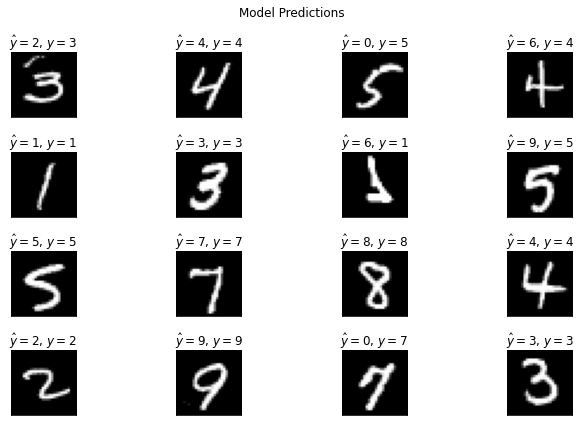

In [33]:
examples = np.random.randint(0, len(test_set), size=16)
batch = torch.stack([test_set[i][0] for i in examples]).reshape(-1, 28 * 28)
y = np.array([test_set[i][1] for i in examples])

with torch.no_grad():
    y_hat = model(prepare_device(batch), beta=beta)
    y_hat = torch.argmax(y_hat.T, dim=1).cpu().numpy()

plot_images(batch.cpu().numpy(), y_hat, y)

Pretty good huh?